In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle
import numpy as np
import mwapi
%matplotlib inline

In [2]:
import datetime

Note that this does not require Cython, the functions are just sped up using the `%%cython` magic

In [3]:
%load_ext Cython

In [4]:
start = datetime.datetime.now()
start

datetime.datetime(2017, 4, 17, 11, 47, 45, 342267)

## Data processing

In [5]:
glob.glob("../../datasets/*bot2bot.tsv")

['../../datasets/dewiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/eswiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/jawiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/zhwiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/ptwiki_20161001_reverted_bot2bot.tsv',
 '../../datasets/enwiki_20161201_reverted_bot2bot.tsv',
 '../../datasets/frwiki_20161001_reverted_bot2bot.tsv']

In [6]:
df_dict = {}
for filename in glob.glob("../../datasets/*bot2bot.tsv"):
    lang_code = filename[15:17]
    df_dict[lang_code] = pd.read_csv(filename, sep="\t")

In [7]:
for lang, lang_df in df_dict.items():
    print(lang, len(lang_df))

de 137844
es 177368
ja 89980
zh 102846
pt 141738
en 1001093
fr 193066


In [8]:
df_dict['en'][0:2].transpose()

,0,1
rev_id,273691771,136526894
rev_timestamp,20090227173507,20070607044209
rev_user,6505923,4534303
rev_user_text,Kbdankbot,PbBot
rev_page,5040439,3046554
rev_sha1,qj45ne2z4yfexmpaz5wfnbm2yrmqt4j,3xtnw7u4w9h6cg1smw97mqnr1en6a55
rev_minor_edit,False,False
rev_deleted,False,False
rev_parent_id,2.59117e+08,1.20932e+08
archived,False,False


### Combining into one dataframe

In [9]:
df_all = df_dict['en'].copy()
df_all = df_all.drop(df_all.index, axis=0)

for lang, lang_df in df_dict.items():
    lang_df['language'] = lang
    df_all = pd.concat([df_all, lang_df])

In [10]:
df_all['language'].value_counts()

en    1001093
fr     193066
es     177368
pt     141738
de     137844
zh     102846
ja      89980
Name: language, dtype: int64

In [11]:
for lang, lang_df in df_dict.items():
    print(lang, len(lang_df))
    


de 137844
es 177368
ja 89980
zh 102846
pt 141738
en 1001093
fr 193066


### Namespace type

In [12]:
def namespace_type(item):
    if int(item) == 0:
        return 'article'
    elif int(item) == 14:
        return 'category'
    elif int(item) % 2 == 1:
        return 'other talk'
    else:
        return 'other page'

In [13]:
df_all['namespace_type'] = df_all['page_namespace'].apply(namespace_type)

In [14]:
df_all['namespace_type'].value_counts()

article       1122392
category       365193
other page     226994
other talk     129356
Name: namespace_type, dtype: int64

### Datetime parsing

In [15]:
def get_year(timestamp):
    return timestamp.year

In [16]:
df_all['reverting_timestamp_dt'] = pd.to_datetime(df_all['reverting_timestamp'], format="%Y%m%d%H%M%S")
df_all['reverted_timestamp_dt'] = pd.to_datetime(df_all['rev_timestamp'], format="%Y%m%d%H%M%S")

df_all = df_all.set_index('reverting_timestamp_dt')

df_all['reverting_timestamp_dt'] = pd.to_datetime(df_all['reverting_timestamp'], format="%Y%m%d%H%M%S")

df_all['time_to_revert'] = df_all['reverting_timestamp_dt']-df_all['reverted_timestamp_dt']

df_all['time_to_revert_hrs'] = df_all['time_to_revert'].astype('timedelta64[s]')/(60*60)

df_all['time_to_revert_days'] = df_all['time_to_revert'].astype('timedelta64[s]')/(60*60*24)

df_all['reverting_year'] = df_all['reverting_timestamp_dt'].apply(get_year)

### enwiki yearly bot-bot revert counts

In [17]:
df_all[df_all['language']=='en'].reverting_year.value_counts().sort_index()

2004         4
2005       262
2006      6238
2007     34084
2008     66228
2009     72846
2010     61780
2011    126814
2012     96084
2013    403111
2014     41188
2015     49194
2016     43260
Name: reverting_year, dtype: int64

### all langauges (in dataset) yearly bot-bot revert counts

In [18]:
df_all.reverting_year.value_counts().sort_index()

2004       604
2005      3196
2006     12714
2007     58850
2008    109978
2009    163096
2010    137000
2011    294004
2012    206238
2013    685235
2014     53466
2015     70826
2016     48728
Name: reverting_year, dtype: int64

### Other processing

In [19]:
def concat_botpair(row):
    return str(row['reverting_user_text']) + " rv " + str(row['rev_user_text'])
    
df_all['botpair'] = df_all.apply(concat_botpair, axis=1)

### Final data format

In [20]:
df_all[0:2].transpose()

reverting_timestamp_dt,2012-01-20 16:44:57,2013-04-04 10:14:44
archived,False,False
language,de,de
page_namespace,14,0
rev_deleted,False,False
rev_id,96266407,101368846
rev_minor_edit,True,True
rev_page,1877152,1877160
rev_parent_id,9.30174e+07,9.3911e+07
rev_revert_offset,1,1
rev_sha1,fx2pgr3i3i4toa5dlkj565cm4q5nihp,h0wxv23bff0urswa5o8d8nsvw0ft12n


# Comments analysis

Function for removing text within square brackets or parentheses, which is useful for aggregating comment messages.

In [21]:
%%cython
# by http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python

def remove_brackets(str test_str):
    """
    Takes a string and returns that string with text in brackets and parentheses removed
    """
    
    test_str = str(test_str)
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
            
    return " ".join(ret.split())

In [22]:
df_all['reverting_comment_nobracket'] = df_all['reverting_comment'].apply(remove_brackets)

### Comment parsing functions

There are two functions that are used to parse comments. `comment_categorization()` runs first and applies a series of pattern matching to comments. If a match is not found, then `interwiki_confirm()` is called, which checks for languages codes in certain patterns that indicate interwiki links.

In [23]:
%%cython
def interwiki_confirm(str comment, str langcode):
    """
    Takes a comment string, searches for language codes bordered by 
    two punctuation marks from [](){},: or one punctuation mark and
    one space. Beginning and end of a comment string counts as a
    space, not a punctuation mark.
    
    Does not recognize the current langcode.
    """
    import string, re
    
    with open("lang_codes.tsv", "r") as f:
        lang_codes = f.read().split("\n")
        
    lang_codes.pop() # a blank '' is in the list that gets returned
    
    lang_codes.remove(langcode)
    
    #print(langcode in lang_codes)
    
    try:
        comment = str(comment)
        comment = comment.lower()
        comment = comment.replace(": ", ":")
        comment = " " + comment + " "  # pad start and end of string with non-punctuation
        #print(comment)
        
    except Exception as e:
        return 'other'
    
    for lang_code in lang_codes:
        
        lang_code_pos = comment.find(lang_code)
        lang_code_len = len(lang_code)
        
        char_before = " "
        char_after = " "
        
        if lang_code_pos >= 0:
            char_before = comment[lang_code_pos-1]
        
            #print("Char before: '", char_before, "'", sep='')
             
            char_after = comment[lang_code_pos+lang_code_len]

            #print("Char after: '", char_after, "'", sep='')
            
            if char_before in string.punctuation and char_after in "[]{}(),:":
                #print(comment, lang_code)
                return 'interwiki link cleanup -- suspected'
            
            elif char_after in string.punctuation and char_before in "[]{}(),:":
                #print(comment, lang_code)
                return 'interwiki link cleanup -- suspected'
            
            elif char_before == " " and char_after in "[]{}(),:":
                #print(comment, lang_code)
                return 'interwiki link cleanup -- suspected'
            
            elif char_after == " " and char_before in "[]{}(),:":
                #print(comment, lang_code)
                return 'interwiki link cleanup -- suspected'               
    return 'other'
    

def comment_categorization(row):
    """
    Takes a row from a pandas dataframe or dict and returns a string with a
    kind of activity based on metadata. Used with df.apply(). Mostly parses
    comments, but makes some use of usernames too.
    """
    
    reverting_user = str(row['reverting_user_text'])
    
    reverted_user = str(row['rev_user_text'])
    
    langcode = str(row['language'])
    
    if reverting_user.find("HBC AIV") >= 0:
        return 'AIV helperbot'
    
    try:
        comment = str(row['reverting_comment'])
    except Exception as e:
        return 'other'
    
    comment_lower = comment.lower().strip()
    comment_lower = " ".join(comment_lower.split())
 
    if comment == 'nan':
        return "deleted revision"
    
    if reverting_user == 'Cyberbot II' and reverted_user == 'AnomieBOT' and comment.find("tagging/redirecting to OCC") >= 0:
        return 'botfight: Cyberbot II vs AnomieBOT date tagging'
        
    if reverting_user == 'AnomieBOT' and reverted_user == 'Cyberbot II' and comment.find("{{Deadlink}}") >= 0:
        return 'botfight: Cyberbot II vs AnomieBOT date tagging'                
    
    elif comment.find("Undoing massive unnecessary addition of infoboxneeded by a (now blocked) bot") >= 0:
        return "botfight: infoboxneeded"
    
    elif comment_lower.find("commonsdelinker") >=0 and reverting_user.find("CommonsDelinker") == -1:
        return "botfight: reverting CommonsDelinker"
        
    elif comment.find("Reverted edits by [[Special:Contributions/ImageRemovalBot") >= 0:
        return "botfight: 718bot vs ImageRemovalBot"
    
    elif comment_lower.find("double redirect") >= 0:
        return "fixing double redirect"
    
    elif comment_lower.find("double-redirect") >= 0:
        return "fixing double redirect"

    elif comment_lower.find("has been moved; it now redirects to") >= 0:
        return "fixing double redirect"
    
    elif comment_lower.find("correction du redirect") >= 0:
        return "fixing double redirect"   
        
    elif comment_lower.find("redirect tagging") >= 0:
        return "redirect tagging/sorting"
    
    elif comment_lower.find("sorting redirect") >= 0:
        return "redirect tagging/sorting"
    
    elif comment_lower.find("redirecciones") >= 0 and comment_lower.find("categoría") >= 0:
        return "category redirect cleanup"    
    
    elif comment_lower.find("change redirected category") >= 0:
        return "category redirect cleanup"
    
    elif comment_lower.find("redirected category") >=0:
        return "category redirect cleanup"
    
    elif comment.find("[[User:Addbot|Bot:]] Adding ") >= 0:
        return "template tagging"
    
    elif comment_lower.find("interwiki") >= 0:
        return "interwiki link cleanup"
    
    elif comment_lower.find("langlinks") >= 0:
        return "interwiki link cleanup"
    
    elif comment_lower.find("iw-link") >= 0:
        return "interwiki link cleanup"
    
    elif comment_lower.find("changing category") >= 0:
        return "moving category"
    
    elif comment_lower.find("recat per") >= 0:
        return "moving category"
    
    elif comment_lower.find("moving category") >= 0:
        return "moving category"
    
    elif comment_lower.find("re-categorisation") >= 0:
        return "moving category"
    
    elif comment_lower.find("recatégorisation") >= 0:
        return "moving category"   
    
    elif comment_lower.find("Updating users status to") >= 0:
        return "user online status update"
    
    elif comment_lower.find("{{Copy to Wikimedia Commons}} either because the file") >= 0:
        return "template cleanup"
        
    elif comment_lower.find("removing a protection template") >= 0:
        return "protection template cleanup"
    
    elif comment_lower.find("removing categorization template") >= 0:
        return "template cleanup"    
    
    elif comment_lower.find("rm ibid template per") >= 0:
        return "template cleanup"      
    
    elif comment_lower.find("page is not protected") >= 0:
        return "template cleanup"          
    
    elif comment_lower.find("removing protection template") >= 0:
        return "template cleanup"      
    
    elif comment_lower.find("removing orphan t") >= 0:
        return "template cleanup"
    
    elif comment_lower.find("non-applicable orphan") >= 0:
        return "template cleanup"
    
    elif comment_lower.find("plantilla") >= 0 and comment_lower.find("huérfano") >= 0:
        return "template cleanup"
    
    elif comment_lower.find("removed orphan t") >= 0:
        return "template cleanup"    
    
    elif comment_lower.find("sandbox") >= 0:
        return "clearing sandbox"
    
    elif comment_lower.find("archiving") >= 0:
        return "archiving"
    
    elif comment_lower.find("duplicate on commons") >= 0:
        return "commons image migration"
    
    elif comment_lower.find("user:mathbot/changes to mathlists") >= 0:
        return "mathbot mathlist updates"
        
    elif comment_lower.find("link syntax") >= 0:
        return "link syntax fixing"
    
    elif comment_lower.find("links syntax") >= 0:
        return "link syntax fixing" 
        
    elif comment_lower.find(" per ") >= 0:
        return "has per justification"  
    
    elif comment_lower.find(" según") >= 0:
        return "has per justification"      
 
    elif comment_lower.find("suite à discussion") >= 0:
        return "has per justification"  
    
    elif comment_lower.find("suite à conservation") >= 0:
        return "has per justification"     
    
    elif comment_lower.find("conforme pedido") >= 0:
        return "has per justification"
    
    elif comment_lower.find("revert") >= 0:
        return "other w/ revert in comment"  
    
    elif comment_lower.find("rv ") >= 0 or comment_lower.find("rv") == 0:
        return "other w/ revert in comment"  
    
    elif comment_lower.find("wikidata") >= 0:
        return "interwiki link cleanup"
    
    elif comment.find("言語間") >=0:
        return "interwiki link cleanup"
        
    elif comment_lower.find("interproyecto") >=0:
        return "interwiki link cleanup"    
        
    elif comment.find("语言链接") >=0:
        return "interwiki link cleanup"  
    
    elif comment.find("双重重定向") >=0 or comment.find("雙重重定向") >= 0:
        return "fixing double redirect"   

    elif comment.find("二重リダイレクト") >=0:
        return "fixing double redirect"  
    
    elif comment_lower.find("doppelten redirect") >=0:
        return "fixing double redirect"  
    
    elif comment_lower.find("doppelte weiterleitung") >=0:
        return "fixing double redirect"      
    
    elif comment_lower.find("redirectauflösung") >=0:
        return "fixing double redirect"      
    
    elif comment_lower.find("doble redirección") >=0 or comment_lower.find("redirección doble") >= 0:
        return "fixing double redirect"  
    
    elif comment_lower.find("redireccionamento duplo") >=0:
        return "fixing double redirect"  

    elif comment_lower.find("duplo redirecionamento") >=0:
        return "fixing double redirect"      
    
    elif comment_lower.find("suppression bandeau") >= 0:
        return "template cleanup"
    
    elif comment_lower.find("archiviert") >= 0:
        return "archiving"
    
    else:
        return interwiki_confirm(comment, langcode)

Testing interwiki confirm

In [24]:
tests_yes = ["Robot adding [[es:Test]]",
             "adding es:Test",
             "linking es, it, en",
             "modifying fr:",
             "modifying:zh",
             "modifying: ja"]

tests_no = ["test", 
            "discuss policies on enwiki vs eswiki", 
            "it is done", 
            "per [[en:WP:AIV]]",
            "it's not its", 
            "its not it's",
            "modifying it all",
            "modifying italy"]

print("Should return interwiki link cleanup -- suspected")
for test in tests_yes:
    print("\t", interwiki_confirm(test, 'en'))

print("Should return other")
for test in tests_no:
    print("\t", interwiki_confirm(test, 'en'))

Should return interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
	 interwiki link cleanup -- suspected
Should return other
	 other
	 other
	 other
	 other
	 other
	 other
	 other
	 other


Apply categorization

In [25]:
%%time
df_all['bottype'] = df_all.apply(comment_categorization, axis=1)

CPU times: user 7min 23s, sys: 5.94 s, total: 7min 29s
Wall time: 7min 29s


## Analysis

Much of what we're interested in are articles, which are in namespace 0. 

In [26]:
df_all_ns0 = df_all[df_all['page_namespace']==0]

### Bottype counts and percentages across all languages in the dataset, articles only

In [27]:
type_counts = df_all_ns0['bottype'].value_counts().rename("count")
type_percent = df_all_ns0['bottype'].value_counts(normalize=True).rename("percent") * 100
type_percent = type_percent.round(2).astype(str) + "%"

pd.concat([type_counts, type_percent], axis=1)

,count,percent
interwiki link cleanup -- suspected,488984,43.57%
interwiki link cleanup,327372,29.17%
fixing double redirect,259022,23.08%
other,20170,1.8%
protection template cleanup,5686,0.51%
moving category,5230,0.47%
other w/ revert in comment,4852,0.43%
category redirect cleanup,3046,0.27%
template cleanup,2596,0.23%
has per justification,1934,0.17%


### Bottype counts and percentages for each language, articles only

In [28]:
counts_dict = {}
for lang in df_all_ns0['language'].unique():

    df_lang_ns0 = df_all_ns0[df_all_ns0['language']==lang]
    
    type_counts = df_lang_ns0['bottype'].value_counts().rename("count")
    type_percent = df_lang_ns0['bottype'].value_counts(normalize=True).rename("percent") * 100
    type_percent = type_percent.round(2).astype(str) + "%"

    counts_dict[lang]=pd.concat([type_counts, type_percent], axis=1)

In [29]:
df_all_ns0['language'].unique()

array(['de', 'es', 'ja', 'zh', 'pt', 'en', 'fr'], dtype=object)

In [30]:
counts_dict['en']

,count,percent
fixing double redirect,220172,45.04%
interwiki link cleanup,168236,34.42%
interwiki link cleanup -- suspected,74204,15.18%
protection template cleanup,5674,1.16%
moving category,4672,0.96%
other,4530,0.93%
category redirect cleanup,2824,0.58%
template cleanup,2318,0.47%
other w/ revert in comment,2014,0.41%
mathbot mathlist updates,1028,0.21%


In [31]:
counts_dict['ja']

,count,percent
interwiki link cleanup -- suspected,55262,79.85%
interwiki link cleanup,11488,16.6%
other,1832,2.65%
fixing double redirect,588,0.85%
other w/ revert in comment,24,0.03%
has per justification,14,0.02%


In [32]:
counts_dict['zh']

,count,percent
interwiki link cleanup -- suspected,47298,54.98%
interwiki link cleanup,30298,35.22%
fixing double redirect,7268,8.45%
other,634,0.74%
other w/ revert in comment,514,0.6%
has per justification,12,0.01%
botfight: reverting CommonsDelinker,6,0.01%


In [33]:
counts_dict['de']

,count,percent
interwiki link cleanup -- suspected,71062,64.71%
interwiki link cleanup,33898,30.87%
other,2758,2.51%
fixing double redirect,1972,1.8%
other w/ revert in comment,44,0.04%
moving category,20,0.02%
has per justification,20,0.02%
protection template cleanup,12,0.01%
template cleanup,10,0.01%
botfight: reverting CommonsDelinker,10,0.01%


In [34]:
counts_dict['fr']

,count,percent
interwiki link cleanup -- suspected,82330,73.18%
interwiki link cleanup,20188,17.94%
fixing double redirect,6592,5.86%
other,2052,1.82%
has per justification,796,0.71%
moving category,538,0.48%
other w/ revert in comment,6,0.01%
clearing sandbox,4,0.0%
botfight: reverting CommonsDelinker,4,0.0%


In [35]:
counts_dict['pt']

,count,percent
interwiki link cleanup -- suspected,83176,69.27%
interwiki link cleanup,29964,24.96%
fixing double redirect,3816,3.18%
other,2986,2.49%
has per justification,72,0.06%
other w/ revert in comment,52,0.04%
clearing sandbox,2,0.0%
botfight: reverting CommonsDelinker,2,0.0%


In [36]:
counts_dict['es']

,count,percent
interwiki link cleanup -- suspected,75652,55.64%
interwiki link cleanup,33300,24.49%
fixing double redirect,18614,13.69%
other,5378,3.96%
other w/ revert in comment,2198,1.62%
has per justification,304,0.22%
template cleanup,268,0.2%
category redirect cleanup,212,0.16%
botfight: reverting CommonsDelinker,32,0.02%
clearing sandbox,2,0.0%


In [37]:
!pip install mwapi

### Validation of interwiki category by diffs

In [38]:
import mwapi
import difflib

session = mwapi.Session('https://en.wikipedia.org', user_agent="Research script by User:Staeiou")

In [39]:
def get_revision(rev_id):
    
    try:
        rev_get = session.get(action='query', prop='revisions', rvprop="content", revids=rev_id)
        rev_pages = rev_get['query']['pages']
        for row in rev_pages.items():
            return(row[1]['revisions'][0]['*'])
    except:
        return np.nan

In [40]:
def get_diff(row):
    #print(row)
    
    try:
        reverted_content = row['reverted_content'].split("\n")
        reverting_content = row['reverting_content'].split("\n")

        diff = difflib.unified_diff(reverted_content, reverting_content)

        return '<br/>'.join(list(diff))
    
    except:
        return np.nan
      

In [41]:
def get_diff_api(row):
    #print(row)
    rev_id = row['rev_id']
    reverting_id = row['reverting_id']
    #print(rev_id, reverting_id)
    rev_get = session.get(action='compare', fromrev=rev_id, torev=reverting_id)
    #print(rev_get)
    return rev_get['compare']['*']


## Get sample for each bottype in en ns0

In [42]:
df_en_ns0 = df_all.query("language == 'en' and page_namespace == 0")
df_en_ns0['bottype'].unique()

array(['moving category', 'interwiki link cleanup',
       'interwiki link cleanup -- suspected', 'fixing double redirect',
       'template cleanup', 'other', 'has per justification',
       'category redirect cleanup', 'botfight: 718bot vs ImageRemovalBot',
       'protection template cleanup', 'redirect tagging/sorting',
       'other w/ revert in comment', 'template tagging',
       'botfight: infoboxneeded', 'botfight: reverting CommonsDelinker',
       'botfight: Cyberbot II vs AnomieBOT date tagging',
       'commons image migration', 'clearing sandbox',
       'mathbot mathlist updates', 'link syntax fixing'], dtype=object)

In [43]:
%%time

df_en_ns0_sample_dict = {}
for bottype in df_en_ns0['bottype'].unique():
    print(bottype)
    type_df = df_en_ns0[df_en_ns0['bottype']==bottype]
    
    if len(type_df) > 5000:
        type_df_sample = type_df.sample(round(len(type_df)/100))
    elif len(type_df) > 100:
        type_df_sample = type_df.sample(100)
    else:
        type_df_sample = type_df

    type_df_sample['reverting_content'] = type_df_sample['reverting_id'].apply(get_revision)
    type_df_sample['reverted_content'] = type_df_sample['rev_id'].apply(get_revision)

    type_df_sample['diff'] = type_df_sample.apply(get_diff, axis=1)
    
    df_en_ns0_sample_dict[bottype] = type_df_sample

moving category
interwiki link cleanup
interwiki link cleanup -- suspected
fixing double redirect
template cleanup
other
has per justification
category redirect cleanup
botfight: 718bot vs ImageRemovalBot
protection template cleanup
redirect tagging/sorting
other w/ revert in comment
template tagging


/home/staeiou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/staeiou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/staeiou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

botfight: infoboxneeded
botfight: reverting CommonsDelinker
botfight: Cyberbot II vs AnomieBOT date tagging
commons image migration
clearing sandbox
mathbot mathlist updates
link syntax fixing
CPU times: user 2min 43s, sys: 3.22 s, total: 2min 47s
Wall time: 37min 56s


In [44]:
import pickle


In [45]:

with open("df_en_ns0_sample_dict.pickle", "wb") as f: 
    pickle.dump(df_en_ns0_sample_dict, f)

In [46]:
pd.options.display.max_colwidth = -1


In [47]:
!mkdir sample_tables/en/ns0

mkdir: cannot create directory ‘sample_tables/en/ns0’: File exists


In [48]:
for bottype, bottype_df in df_en_ns0_sample_dict.items():
    
   
    bottype_file = bottype.replace(" ", "_")
    bottype_file = bottype_file.replace("/", "_")
    filename = "sample_tables/en/ns0/en_ns0_sample_" + bottype_file + ".html"
    
    bottype_df[['reverting_id','reverting_user_text',
                             'rev_user_text',
                             'reverting_comment',
                             'diff']].to_html(filename, escape=False)
    
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write("<a name='" + bottype + "'><h1>" + bottype + "</h1></a>\r\n")
        f.write(content)

In [49]:
!cat sample_tables/en/ns0/*.html > sample_tables/en/ns0/en_ns0_sample_all.html

In [50]:
with open("sample_tables/en/ns0/en_ns0_sample_all.html", 'r+') as f:
    content = f.read()
    f.seek(0, 0)
    f.write("<head><meta charset='UTF-8'></head>\r\n<body>")
    f.write("""<style>
                .dataframe {
                    border:1px solid #C0C0C0;
                    border-collapse:collapse;
                    padding:5px;
                    table-layout:fixed;
                }
                .dataframe th {
                    border:1px solid #C0C0C0;
                    padding:5px;
                    background:#F0F0F0;
                }
                .dataframe td {
                    border:1px solid #C0C0C0;
                    padding:5px;
                }
            </style>""")
    f.write("<table class='dataframe'>")
    f.write("<thead><tr><th>Bot type</th><th>Total count in enwiki ns0</th><th>Number of sample diffs</th>")
    
    for bottype, bottype_df in df_en_ns0_sample_dict.items():
        
        len_df = str(len(df_en_ns0[df_en_ns0['bottype']==bottype]))
        len_sample = str(len(bottype_df))
        
        toc_str = "<tr><td><a href='#" + bottype + "'>" + bottype + "</a></td>\r\n"
        toc_str += "<td>" + len_df + "</td>"
        toc_str += "<td>" + len_sample + "</td></tr>"
        f.write(toc_str)
    f.write("</table>")
    f.write(content)

## Get sample for each bottype in fr ns0

In [51]:
df_fr_ns0 = df_all.query("language == 'fr' and page_namespace == 0")
df_fr_ns0['bottype'].unique()

array(['interwiki link cleanup -- suspected', 'interwiki link cleanup',
       'other', 'has per justification', 'fixing double redirect',
       'moving category', 'other w/ revert in comment',
       'botfight: reverting CommonsDelinker', 'clearing sandbox'], dtype=object)

In [52]:
%%time

df_fr_ns0_sample_dict = {}
for bottype in df_fr_ns0['bottype'].unique():
    print(bottype)
    type_df = df_fr_ns0[df_fr_ns0['bottype']==bottype]
    
    if len(type_df) > 5000:
        type_df_sample = type_df.sample(round(len(type_df)/100))
    elif len(type_df) > 100:
        type_df_sample = type_df.sample(100)
    else:
        type_df_sample = type_df

    type_df_sample['reverting_content'] = type_df_sample['reverting_id'].apply(get_revision)
    type_df_sample['reverted_content'] = type_df_sample['rev_id'].apply(get_revision)

    type_df_sample['diff'] = type_df_sample.apply(get_diff, axis=1)
    
    df_fr_ns0_sample_dict[bottype] = type_df_sample

interwiki link cleanup -- suspected
interwiki link cleanup
other
has per justification
fixing double redirect
moving category
other w/ revert in comment


/home/staeiou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/staeiou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/staeiou/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

botfight: reverting CommonsDelinker
clearing sandbox
CPU times: user 41.6 s, sys: 956 ms, total: 42.6 s
Wall time: 8min 48s


In [53]:
import pickle


In [54]:
with open("df_en_ns0_sample_dict.pickle", "wb") as f: 
    pickle.dump(df_en_ns0_sample_dict, f)

In [55]:
pd.options.display.max_colwidth = -1


In [56]:
!mkdir sample_tables/en/ns0

mkdir: cannot create directory ‘sample_tables/en/ns0’: File exists


In [57]:
for bottype, bottype_df in df_fr_ns0_sample_dict.items():
    
   
    bottype_file = bottype.replace(" ", "_")
    bottype_file = bottype_file.replace("/", "_")
    filename = "sample_tables/fr/ns0/fr_ns0_sample_" + bottype_file + ".html"
    
    bottype_df[['reverting_id','reverting_user_text',
                             'rev_user_text',
                             'reverting_comment',
                             'diff']].to_html(filename, escape=False)
    
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write("<a name='" + bottype + "'><h1>" + bottype + "</h1></a>\r\n")
        f.write(content)

In [58]:
!cat sample_tables/en/ns0/*.html > sample_tables/en/ns0/en_ns0_sample_all.html

In [59]:
with open("sample_tables/fr/ns0/fr_ns0_sample_all.html", 'r+') as f:
    content = f.read()
    f.seek(0, 0)
    f.write("<head><meta charset='UTF-8'></head>\r\n<body>")
    f.write("""<style>
                .dataframe {
                    border:1px solid #C0C0C0;
                    border-collapse:collapse;
                    padding:5px;
                    table-layout:fixed;
                }
                .dataframe th {
                    border:1px solid #C0C0C0;
                    padding:5px;
                    background:#F0F0F0;
                }
                .dataframe td {
                    border:1px solid #C0C0C0;
                    padding:5px;
                }
            </style>""")
    f.write("<table class='dataframe'>")
    f.write("<thead><tr><th>Bot type</th><th>Total count in frwiki ns0</th><th>Number of sample diffs</th>")
    
    for bottype, bottype_df in df_en_ns0_sample_dict.items():
        
        len_df = str(len(df_en_ns0[df_en_ns0['bottype']==bottype]))
        len_sample = str(len(bottype_df))
        
        toc_str = "<tr><td><a href='#" + bottype + "'>" + bottype + "</a></td>\r\n"
        toc_str += "<td>" + len_df + "</td>"
        toc_str += "<td>" + len_sample + "</td></tr>"
        f.write(toc_str)
    f.write("</table>")
    f.write(content)

### What was not categorized?

In [60]:
other_count = 0
for comment, count in df_all[df_all['bottype']=='interwiki link cleanup -- suspected']['reverting_comment'].value_counts().iteritems():
    if count > 25:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

374 	 Bot: Mudança automática  (-[Ff]lag[_ ]of[_ ]Roraima.svg +Bandeira de Roraima.svg)
274 	 +:zh-cn fix:zh
218 	 Bot: Mudança automática  (-[Ff]lag[_ ]of[_ ]Rio[_ ]Grande[_ ]do[_ ]Sul.svg +Bandeira Estado RioGrandedoSul Brasil.svg)
172 	 robot  Modificado: en
146 	 Updating users status to: online (BOT EDIT)
128 	 r2.7.1) (robot Modificado: [[ce:Тоба:Vikipediya:Kuckepaş]]
124 	 trocando categoria - pedido em [[WP:CR]] utilizando [[Wikipedia:AutoWikiBrowser|AWB]]
120 	 r2.7.1) (robot Modificado: [[ce:Кадегар:Vikipediya:Kuckepaş]]
118 	 Bot: Mudança automática  (-[Ff]lag[_ ]of[_ ]Bahia.svg +Bandeira da Bahia.svg)
116 	 robot  Adding: sk
116 	 r2.7.1) (機器人 修改: [[ce:Тоба:Vikipediya:Kuckepaş]]
112 	 robot  Añadido: pl
112 	 r2.7.1) (ロボットによる 変更: [[ce:Тоба:Vikipediya:Kuckepaş]]
112 	 r2.7.1) (Bot: Modificando: [[ce:Тоба:Vikipediya:Kuckepaş]]
108 	 r2.7.1) (機器人 修改: [[ce:Кадегар:Vikipediya:Kuckepaş]]
108 	 +:zh-tw,zh-cn fix:zh
108 	 r2.7.1) (robot Modifying: [[ce:Тоба:Vikipediya:Kuckepaş]]
10

In [61]:
other_count = 0
for comment, count in df_all[df_all['bottype']=='other']['reverting_comment_nobracket'].value_counts().iteritems():
    if count > 25:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

7268 	 Removing redlinks.
3364 	 No broken #section links left
3036 	 Robot: Automatically cleaned
2084 	 Bot: Entferne:
1752 	 Robot : Remplacement modèle {{Wikiprojet droit/rattachement précis non vérifié}} par {{Wikiprojet droit}}
1696 	 r2.7.1)
1668 	 Bot: Automatically cleaned
1648 	 BOT: Removing {{Copy to Wikimedia Commons}} either because the file no longer meets the criteria for or because the file is already on Commons.
1520 	 WildBot was summoned
1500 	 取消（）的编辑；更改回的最后一个版本
1456 	 Automated archival of 1 sections to
1082 	 mise en forme
1040 	 Removing completed dates from holding cell. Errors?
984 	 BOT: removing {{}} either because the file no longer meets the criteria for or because the file is already on Commons
910 	 -
902 	 No ambiguous links left
892 	 Robô: A corrigir o redirecionamento duplo para
872 	 r2.7.3)
806 	 机器人: 加速才女机器人更新
714 	 r2.7.2)
670 	 bot: 「削除告知」
632 	 Tagging for a wikiproject using tag {{WikiProject Genetics|class=|importance=|imageneeded=|imagedetai

In [62]:
other_count = 0
for comment, count in df_all[df_all['bottype']=='other']['reverting_comment'].value_counts().iteritems():
    if count > 25:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

7268 	 Removing redlinks.
3364 	 No broken #section links left
3036 	 Robot: Automatically cleaned
1752 	 Robot : Remplacement modèle {{Wikiprojet droit/rattachement précis non vérifié}} par {{Wikiprojet droit}}
1668 	 Bot: Automatically cleaned
1648 	 BOT: Removing {{Copy to Wikimedia Commons}} either because the file no longer meets the criteria for [[WP:TRANSFER|transfer]] or because the file is already on Commons.
1520 	 WildBot was summoned
1082 	 mise en forme
1040 	 (BOT) Removing completed dates from holding cell. Errors? [[User:AnomieBOT/shutoff/PUICloser]]
984 	 BOT: removing {{[[Template:Copy to Wikimedia Commons|Copy to Wikimedia Commons]]}} either because the file no longer meets the criteria for [[WP:TRANSFER|transfer]] or because the file is already on Commons
910 	 -
902 	 No ambiguous links left
670 	 bot: [[Wikipedia:リダイレクトの削除依頼]]「削除告知」
632 	 Tagging for a wikiproject using tag {{WikiProject Genetics|class=|importance=|imageneeded=|imagedetails=|unref=}}
616 	 No ambi

In [63]:
len(df_lang_ns0)

112510

In [64]:
lang_l = 'es'
other_count = 0
df_lang_ns0 = df_all_ns0[df_all_ns0['language']==lang_l]

for comment, count in df_lang_ns0[df_lang_ns0['bottype']=='other']['reverting_comment'].value_counts().iteritems():
    if count > 5:
        print(count, "\t", comment)
    else:
        other_count = other_count + count
print(other_count, "\tOther cases")

114 	 -
78 	 Bot: trasladando categoría - [[Categoría:Personajes de El señor de los anillos]] (v1.34)
74 	 Fusión de plantillas
60 	 Bot: Cambiando #REDIRECT por #REDIRECCIÓN.
60 	 Bot: [[Usuario:FrescoBot/Enlaces|sintaxis de los enlaces]]
46 	 Bot: idioma = Inglés.
36 	 Robot: modificadas Categoría:Juzgados por el Tribunal Penal Internacional para la ex Yugoslavia a Categoría:Juzgados por el Tribunal Penal Internacional para la ex-Yugoslavia
34 	 Bot: Cambiada Categoría:Ciclistas de la Comunidad Foral de Navarra
32 	 Robot: Retirando {{[[Template:Semiprotegida|Semiprotegida]]}} por no estar protegido
30 	 Robot: modificadas Categoría:Juzgados por el Tribunal Penal Internacional para la ex-Yugoslavia a Categoría:Juzgados por el Tribunal Penal Internacional para la ex Yugoslavia
30 	 Bot: Cambiada Categoría:Monumentos de Zamora
28 	 [[Usuario:Bigsus-bot/Corrector ortográfico|Bot]]: Arreglando referencias y otros
24 	 Pequeñas correcciones [[WP:CEM]].
24 	 Bot: Moviendo categoría
22 	 r2

## How long did this take to run?

In [65]:
end = datetime.datetime.now()
end

datetime.datetime(2017, 4, 17, 12, 48, 31, 722292)

In [66]:
time_to_run = end - start
minutes = int(time_to_run.seconds/60)
seconds = time_to_run.seconds % 60
print("Total runtime: ", minutes, "minutes, ", seconds, "seconds")

Total runtime:  60 minutes,  46 seconds


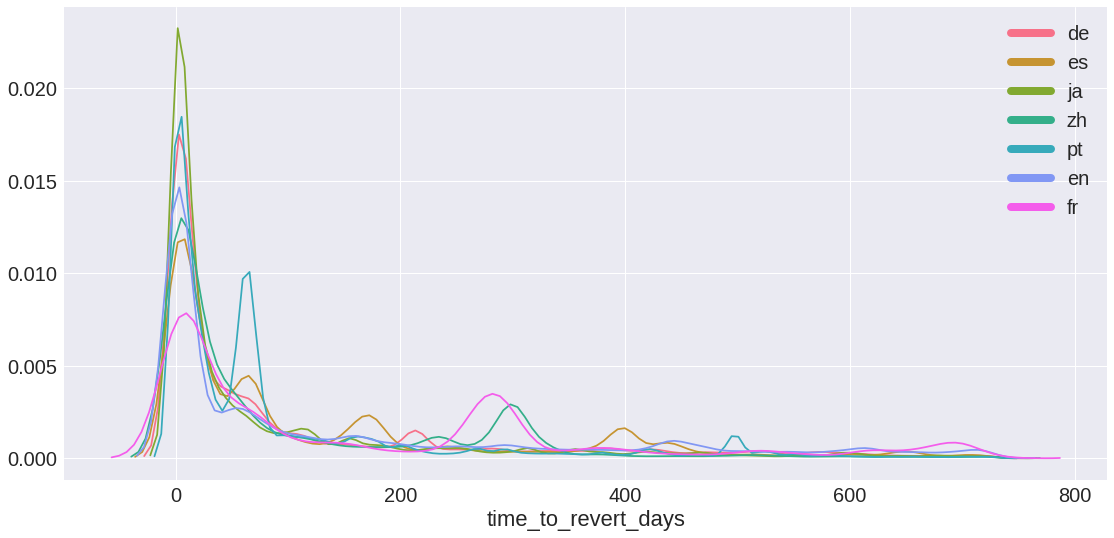

In [67]:
sns.set(font_scale=2)
pal = sns.color_palette("husl", 7)
g = sns.FacetGrid(df_all, palette=pal, hue="language", size=8, aspect=2)
g.map(sns.kdeplot, "time_to_revert_days", clip=[0,(365*2)])
#g.add_legend()
leg = plt.legend()

for legobj in leg.legendHandles:
    legobj.set_linewidth(8.0)

## Export possible botfights

In [68]:
def is_possible_botfight(bottype_str):
    if bottype_str == 'other':
        return True
    elif bottype_str == 'other w/ revert in comment':
        return True
    elif bottype_str.find('botfight') >= 0:
        return True
    else:
        return False

In [69]:
df_possible_botfights_mask = df_all['bottype'].apply(is_possible_botfight)

In [70]:
df_possible_botfights = df_all[df_possible_botfights_mask]
df_possible_botfights_ns0 = df_possible_botfights[df_possible_botfights['page_namespace']==0]

In [71]:
df_possible_botfights['language'].value_counts()

en    50125
es    9876 
fr    6174 
de    6168 
zh    5336 
pt    3728 
ja    2116 
Name: language, dtype: int64

In [72]:
df_possible_botfights_ns0['language'].value_counts()

en    8142
es    7608
pt    3040
de    2814
fr    2062
ja    1856
zh    1154
Name: language, dtype: int64

In [73]:
df_possible_botfights[0:2].transpose()

reverting_timestamp_dt,2010-11-25 13:37:40,2011-09-01 06:01:21
archived,False,False
language,de,de
page_namespace,0,0
rev_deleted,False,False
rev_id,81826985,92814820
rev_minor_edit,True,True
rev_page,4970640,1883148
rev_parent_id,7.78714e+07,9.00531e+07
rev_revert_offset,1,1
rev_sha1,gjkzzrawns34qsxbyrhhjdtigs8xluj,dy0u870vlr8qmtjco1tvyzpjedcaca5


In [74]:
df_possible_botfights.to_pickle("data/possible_botfights.pickle")
df_possible_botfights.to_csv("data/possible_botfights.tsv", sep="\t")